# Testing Adaptive Learning with Simulations

### Import Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/qinfer/.*')
from __future__ import division # Ensures that a/b is always a float.

In [2]:
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m

reload(m)

<module 'models' from 'models.pyc'>

In [3]:
parallel=True
if parallel:
    from ipyparallel import Client
    rc = Client()
    dview = rc[:]
    dview.use_dill()
    
    with dview.sync_imports():
        import os

    # Change directory on engines so that we can import models.
    if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
        print "Changed engine directories to notebook directory."
        
    # To ensure that we don't enter into a Matplotlib event loop
    # on our engines, we set the MPLBACKEND to the non-interactive
    # Agg backend first. This is especially useful if the engines
    # are connected via SSH.
    if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
        print "Changed MPL backend."
        
    # Force each engine to import QInfer before proceeding.
    if dview.execute('import qinfer as qi').get():
        print "Successfully imported QInfer on engines."
        
    if dview.execute('import models').get():
        print "Successfully imported models."
    
    print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


### Setup

Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [4]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = True
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

### Initialize QInfer Objects

In [5]:
ham_model = m.RabiRamseyModel()
ham_model._Q = np.array([1,1,0,0,0])

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")
 - wo: Carrier offset from 2870MHz, positive or negative (MHz)

In [6]:
true_value = np.array([5.555, 1.432, 0.579, 2.171, 0.25])
target_stds = np.array([0.01,0.005,0.01,0.005,0.01])
wide_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1]
        ]))
narrow_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)
medium_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    10*target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)

In [7]:
def rabi_sweep(min_t=None, max_t=0.3, n=50, n_bin=None, wo=0):
    if min_t is None:
        min_t = max_t / n
    vals = [
        np.linspace(min_t, max_t, n),
        np.zeros(n),
        np.zeros(n),
        np.ones(n) * wo,
        np.ones(n) * ham_model.RABI
    ]
    dtype = ham_model.expparams_dtype
    if n_bin is not None:
        vals = vals + [(n_bin * np.ones(n)).astype(np.int)]
        dtype = dtype + [('n_meas','int')]
    rabi_eps = np.array(vals).T
    rabi_eps = np.array(list(zip(*rabi_eps.T)), dtype=dtype)
    return rabi_eps

def ramsey_sweep(min_tau=None, max_tau=2, tp=0.01, phi=0, n=50, n_bin=None, wo=0):
    if min_tau is None:
        min_tau = max_tau / n
    vals = [
        tp * np.ones(n),
        np.linspace(min_tau, max_tau, n),
        phi * np.ones(n),
        np.ones(n) * wo,
        np.ones(n) * ham_model.RAMSEY
    ]
    dtype = ham_model.expparams_dtype
    if n_bin is not None:
        vals = vals + [(n_bin * np.ones(n)).astype(np.int)]
        dtype = dtype + [('n_meas','int')]
    ramsey_eps = np.array(vals).T
    ramsey_eps = np.array(list(zip(*ramsey_eps.T)), dtype=dtype)
    return ramsey_eps

###  Simulation Tests

(0, 1)

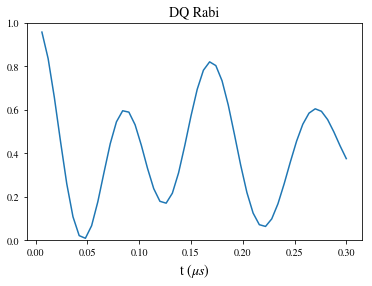

In [8]:
rabi_eps = rabi_sweep(max_t=0.3,n=50)
plt.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:])
plt.title('DQ Rabi')
plt.xlabel('t $(\mu s)$')
plt.ylim(0,1)

(0, 1)

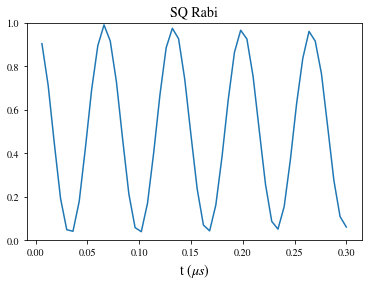

In [9]:
rabi_eps = rabi_sweep(max_t=0.3,n=50,wo=50)
params = true_value[np.newaxis,:]+np.array([5,-50,0,0,0])
plt.plot(rabi_eps['t'], ham_model.likelihood(0, params, rabi_eps)[0,0,:])
plt.title('SQ Rabi')
plt.xlabel('t $(\mu s)$')
plt.ylim([0,1])

(0, 1)

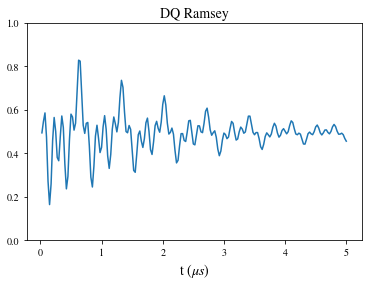

In [10]:
tp_est = 1 / true_value[0] / 4

ramsey_eps = ramsey_sweep(max_tau=5,n=200,tp=tp_est,phi=np.pi)
plt.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:])

plt.title('DQ Ramsey')
plt.xlabel('t $(\mu s)$')
plt.ylim([0,1])

### Speed Tests

In [11]:
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(10000), rabi_sweep(max_t=0.3,n=50))
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(10000), ramsey_sweep(max_tau=2,n=50))
if parallel:
    %timeit -n1 -r1 qi.DirectViewParallelizedModel(ham_model,dview).likelihood(1, wide_prior.sample(10000), rabi_sweep(max_t=0.3,n=50))
    %timeit -n1 -r1 qi.DirectViewParallelizedModel(ham_model,dview).likelihood(1, wide_prior.sample(10000), ramsey_sweep(max_tau=2,n=50))

1 loop, best of 1: 11.1 s per loop
1 loop, best of 1: 21.1 s per loop
1 loop, best of 1: 1.57 s per loop
1 loop, best of 1: 2.73 s per loop


In [12]:
updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(ramsey_eps)
%timeit -n1 -r1 updater.expected_information_gain(rabi_eps)
%timeit -n1 -r1 updater.expected_information_gain(ramsey_eps)
if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
    %timeit -n1 -r1 updater.bayes_risk(rabi_eps)
    %timeit -n1 -r1 updater.bayes_risk(ramsey_eps)
    %timeit -n1 -r1 updater.expected_information_gain(rabi_eps)
    %timeit -n1 -r1 updater.expected_information_gain(ramsey_eps)

1 loop, best of 1: 5.5 s per loop
1 loop, best of 1: 10.3 s per loop
1 loop, best of 1: 5.51 s per loop
1 loop, best of 1: 10.2 s per loop
1 loop, best of 1: 847 ms per loop
1 loop, best of 1: 1.47 s per loop
1 loop, best of 1: 772 ms per loop
1 loop, best of 1: 1.3 s per loop


###  Test Risk and Information Gain

Overwriting ../fig/risk-and-ig-tight-prior.png
Overwriting ../fig/risk-and-ig-tight-prior.pdf


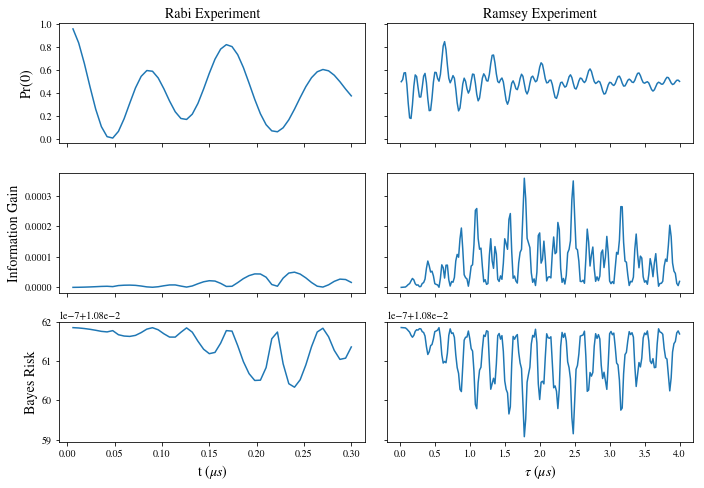

In [13]:
if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
else:
    updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
ham_model._Q = np.array([1,1,1,1,1])

fig = plt.figure(figsize=(10,7))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_ig = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_risk = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_ig.plot(rabi_eps['t'], updater.expected_information_gain(rabi_eps), label='Rabi EIG')
ax_rabi_risk.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps)), label='Rabi Bayes Risk')

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_ig = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_ig)
ax_ramsey_risk = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_risk)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=4,n=200,tp=tp_est)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_ig.plot(ramsey_eps['tau'], updater.expected_information_gain(ramsey_eps), label='Ramsey EIG')
ax_ramsey_risk.plot(ramsey_eps['tau'], np.sqrt(updater.bayes_risk(ramsey_eps)), label='Ramsey Bayes Risk')

plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_ig.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
ax_rabi_risk.set_xlabel(r't $(\mu s)$')
ax_ramsey_risk.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_ig.set_ylabel('Information Gain')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_risk.set_ylabel('Bayes Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()

export_figure(fig, 'risk-and-ig-tight-prior')

Overwriting ../fig/risk-and-ig-compare-strategies.png
Overwriting ../fig/risk-and-ig-compare-strategies.pdf


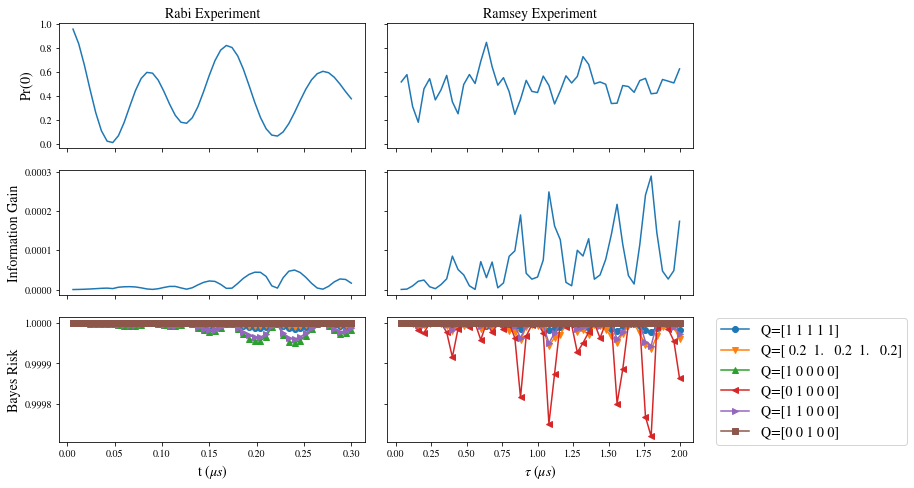

In [14]:
def weighted_variance(updater):
    xs = updater.particle_locations-updater.est_mean()
    xs = np.sum(updater.model.Q * xs**2, axis=1)
    return np.sum(updater.particle_weights * xs)

if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
else:
    updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
Qs = [
    np.array([1,1,1,1,1]),
    np.array([0.2,1,0.2,1,0.2]),
    np.array([1,0,0,0,0]),
    np.array([0,1,0,0,0]),
    np.array([1,1,0,0,0]),
    np.array([0,0,1,0,0]),
]

fig = plt.figure(figsize=(10,7))
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_ig = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_risk = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_ig.plot(rabi_eps['t'], updater.expected_information_gain(rabi_eps), label='Rabi EIG')

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_ig = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_ig)
ax_ramsey_risk = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_risk)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=2,n=50,tp=tp_est)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_ig.plot(ramsey_eps['tau'], updater.expected_information_gain(ramsey_eps), label='Ramsey EIG')

for idx_Q, Q in enumerate(Qs):
    marker = markers.next()
    ham_model._Q = Q
    
    ax_rabi_risk.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps) / weighted_variance(updater)), marker=marker, label='Q={}'.format(Q))
    ax_ramsey_risk.plot(ramsey_eps['tau'], np.sqrt(updater.bayes_risk(ramsey_eps) / weighted_variance(updater)), marker=marker, label='Q={}'.format(Q))


plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_ig.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
ax_rabi_risk.set_xlabel(r't $(\mu s)$')
ax_ramsey_risk.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_ig.set_ylabel('Information Gain')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_risk.set_ylabel('Bayes Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()
plt.sca(ax_ramsey_risk)
plt.legend(bbox_to_anchor=(1.05, 1.05))

export_figure(fig, 'risk-and-ig-compare-strategies')

Overwriting ../fig/risk-bern-vs-bin.png
Overwriting ../fig/risk-bern-vs-bin.pdf


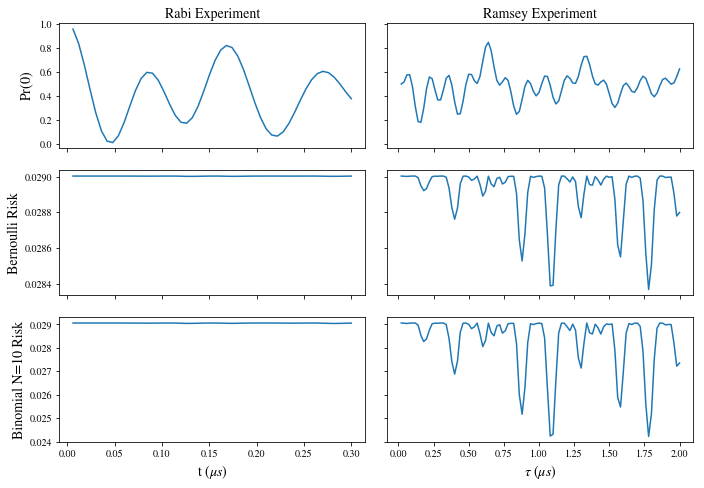

In [15]:
bern_model = m.RabiRamseyModel()
bin_model = qi.BinomialModel(bern_model)
updater_bern = qi.SMCUpdater(bern_model, 5000, medium_prior)
updater_bin = qi.SMCUpdater(bin_model, 5000, medium_prior)
bern_model._Q = np.array([0,1,0,0,0])
bin_model._Q = np.array([0,1,0,0,0])

fig = plt.figure(figsize=(10,7))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_bern = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_bin = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50,n_bin=10)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_bern.plot(rabi_eps['t'], np.sqrt(updater_bern.bayes_risk(rabi_eps)))
ax_rabi_bin.plot(rabi_eps['t'], np.sqrt(updater_bin.bayes_risk(rabi_eps)))

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_bern = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_bern)
ax_ramsey_bin = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_bin)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=tp_est,n_bin=10)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_bern.plot(ramsey_eps['tau'], np.sqrt(updater_bern.bayes_risk(ramsey_eps)))
ax_ramsey_bin.plot(ramsey_eps['tau'], np.sqrt(updater_bin.bayes_risk(ramsey_eps)))

plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_bern.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_bern.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_bern.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_bin.get_yticklabels(), visible=False)
ax_rabi_bin.set_xlabel(r't $(\mu s)$')
ax_ramsey_bin.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_bern.set_ylabel('Bernoulli Risk')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_bin.set_ylabel('Binomial N=10 Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()

export_figure(fig, 'risk-bern-vs-bin')

### Heuristics

In [ ]:
class RiskHeuristic(qi.Heuristic):
    def __init__(self, updater, Q, rabi_eps, ramsey_eps):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._ham_model._Q = Q
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Bayes Risk, Q={}".format(Q)
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        risk = self._risk_taker.bayes_risk(all_eps)
        self.risk_history += [risk]
        best_idx = np.argmin(risk, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps
    
class InfoGainHeuristic(qi.Heuristic):
    def __init__(self, updater, rabi_eps, ramsey_eps):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Expected Information Gain"
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        eig = self._risk_taker.expected_information_gain(all_eps)
        self.risk_history += [eig]
        best_idx = np.argmax(eig, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps
    
class ExponentialHeuristic(qi.Heuristic):
    def __init__(self, updater, max_t=0.3, max_tau=2, base=11/10, n=50, n_bin=100):
        self.updater = updater
        self._rabi_eps = rabi_sweep(max_t=1, n=n, n_bin=n_bin)
        self._ramsey_eps = ramsey_sweep(max_tau=1, n=n, n_bin=n_bin)
        
        self._rabi_eps['t'] = max_t * (base ** np.arange(n)) / (base ** (n-1))
        self._ramsey_eps['tau'] = max_tau * (base ** np.arange(n)) / (base ** (n-1))
        
        self._rabi_eps['t'] = np.round(self._rabi_eps['t'] / 0.002) * 0.002
        self._ramsey_eps['tau'] = np.round(self._ramsey_eps['tau'] / 0.002) * 0.002
        
        self._idx = 0
        self.name = "Exponentially Sparse Heur"
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.vstack([self._rabi_eps, ramsey_eps]).reshape((-1,), order='F')
        
        eps =  np.array([all_eps[self._idx]])
        self._idx += 1
        return eps
    
class LinearHeuristic(qi.Heuristic):
    def __init__(self, updater, max_t=0.3, max_tau=2, n=50, n_bin=100):
        self.updater = updater
        self._rabi_eps = rabi_sweep(max_t=1, n=n, n_bin=n_bin)
        self._ramsey_eps = ramsey_sweep(max_tau=1, n=n, n_bin=n_bin)
        
        self._rabi_eps['t'] = np.round(self._rabi_eps['t'] / 0.002) * 0.002
        self._ramsey_eps['tau'] = np.round(self._ramsey_eps['tau'] / 0.002) * 0.002
        
        self._idx = 0
        self.name = "Standard Linear Heuristic"
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.vstack([self._rabi_eps, ramsey_eps]).reshape((-1,), order='F')
        
        eps =  np.array([all_eps[self._idx]])
        self._idx += 1
        return eps

### Adaptive Simulations

In [ ]:
n_bin = 10
n_particles = 10000
n_experiments = 100
n_trials = 20

def make_updater():
    if not parallel:
        return qi.BinomialModel(m.RabiRamseyModel())
    else:
        return qi.DirectViewParallelizedModel(qi.BinomialModel(m.RabiRamseyModel()), dview, serial_threshold=1)

Qs = [
    np.array([1,1,1,1,1]),
    np.array([1,0,0,0,0]),
    np.array([0,1,0,0,0]),
    np.array([1,1,0,0,0]),
    np.array([0,0,1,0,0])
]
n_updaters = len(Qs) + 3

heuristics = []

track_means = np.zeros((n_trials, n_updaters, n_experiments + 1, 5))
track_covs = np.zeros((n_trials, n_updaters, n_experiments + 1, 5, 5))

for idx_trial in range(10):
    heuristics.append([])
    heuristics[-1] = [
        RiskHeuristic(
            qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
            Q, 
            rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
            ramsey_sweep(max_tau=2, n=50, n_bin=n_bin)
        )
        for Q in Qs
    ]

    heuristics[-1] += [InfoGainHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
        rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
        ramsey_sweep(max_tau=2, n=50, n_bin=n_bin)
    )]
    heuristics[-1] += [ExponentialHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior),
        max_t=0.5, max_tau=2, base=11/10, n=50, n_bin=n_bin
    )]
    heuristics[-1] += [LinearHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior),
        max_t=0.5, max_tau=2, n=50, n_bin=n_bin
    )]

    n_updaters = len(heuristics[-1])

    for idx_h, h in enumerate(heuristics[-1]):
        track_means[idx_trial,idx_h, 0, :] = h.updater.est_mean()
        track_covs[idx_trial,idx_h, 0, :, :] = h.updater.est_covariance_mtx()

    for idx_eps in range(n_experiments):

        for idx in range(n_updaters):
            heuristic = heuristics[-1][idx]
            updater = heuristic.updater

            #estimate ramsey pulse time
            current_est = updater.est_mean()
            tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002

            #decide experiment
            eps = heuristic(tp_est)
            print("{}: {} : {}".format(idx_eps, heuristic.name, eps[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))

            # simulate outcome
            outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps)

            # update
            updater.update(outcome, eps)

            # store info
            track_means[idx_trial,idx, idx_eps + 1, :] = updater.est_mean()
            track_covs[idx_trial,idx, idx_eps + 1, :, :] = updater.est_covariance_mtx()
        print "---"

0: Bayes Risk, Q=[1 1 1 1 1] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2884.  2874.  2881.   577.   285.]
0: Bayes Risk, Q=[1 0 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2908.  2890.  2904.   580.   285.]
0: Bayes Risk, Q=[0 1 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2888.  2885.  2901.   577.   287.]
0: Bayes Risk, Q=[1 1 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2875.  2900.  2881.   574.   285.]
0: Bayes Risk, Q=[0 0 1 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2864.  2907.  2899.   574.   288.]
0: Expected Information Gain : ( 0.03,  0.,  0.,  0., 0, 10) [ 2884.  2895.  2877.   574.   284.]
0: Exponentially Sparse Heur : ( 0.004,  0.,  0.,  0., 0, 10) [ 2882.  2908.  2873.   579.   286.]
0: Standard Linear Heuristic : ( 0.02,  0.,  0.,  0., 0, 10) [ 2878.  2878.  2884.   575.   287.]
---
1: Bayes Risk, Q=[1 1 1 1 1] : ( 0.05,  0.,  0.,  0., 0, 10) [ 1309.  2792.  2987.   573.   279.]
1: Bayes Risk, Q=[1 0 0 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [ 1346.  2835.  3067.   581.   282.]
1: Bayes Risk, 

10: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.2,  0.,  0., 1, 10) [  191.   362.  1916.   338.   254.]
10: Bayes Risk, Q=[0 0 1 0 0] : ( 0.47,  0.,  0.,  0., 0, 10) [  284.   806.  1505.   590.   258.]
10: Expected Information Gain : ( 0.048,  0.16,  0.,  0., 1, 10) [  249.  1370.  2662.   341.   225.]
10: Exponentially Sparse Heur : ( 0.008,  0.,  0.,  0., 0, 10) [ 1309.  2208.  2824.   559.   272.]
10: Standard Linear Heuristic : ( 0.12,  0.,  0.,  0., 0, 10) [  933.  2806.  2326.   579.   275.]
---
11: Bayes Risk, Q=[1 1 1 1 1] : ( 0.16,  0.,  0.,  0., 0, 10) [ 1127.  3942.  2428.   420.   262.]
11: Bayes Risk, Q=[1 0 0 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  247.   835.  2611.   393.   270.]
11: Bayes Risk, Q=[0 1 0 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [  816.  2379.  2490.   562.   264.]
11: Bayes Risk, Q=[1 1 0 0 0] : ( 0.24,  0.,  0.,  0., 0, 10) [  200.   347.  1934.   334.   247.]
11: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.08,  0.,  0., 1, 10) [  253.   881.  1555.   635.   247

20: Expected Information Gain : ( 0.046,  0.32,  0.,  0., 1, 10) [  183.   869.  2165.   202.   200.]
20: Exponentially Sparse Heur : ( 0.012,  0.,  0.,  0., 0, 10) [ 1049.  2572.  2813.   485.   253.]
20: Standard Linear Heuristic : ( 0.22,  0.,  0.,  0., 0, 10) [  851.  2404.  1926.   335.   262.]
---
21: Bayes Risk, Q=[1 1 1 1 1] : ( 0.17,  0.,  0.,  0., 0, 10) [  238.   757.  1618.   268.   217.]
21: Bayes Risk, Q=[1 0 0 0 0] : ( 0.17,  0.,  0.,  0., 0, 10) [  144.   553.  1749.   275.   249.]
21: Bayes Risk, Q=[0 1 0 0 0] : ( 0.17,  0.,  0.,  0., 0, 10) [  184.   512.  1661.   311.   254.]
21: Bayes Risk, Q=[1 1 0 0 0] : ( 0.4,  0.,  0.,  0., 0, 10) [  122.   236.  1991.   310.   216.]
21: Bayes Risk, Q=[0 0 1 0 0] : ( 0.49,  0.,  0.,  0., 0, 10) [   97.   131.  1026.   139.   229.]
21: Expected Information Gain : ( 0.046,  0.36,  0.,  0., 1, 10) [  195.   979.  2353.   216.   206.]
21: Exponentially Sparse Heur : ( 0.042,  0.048,  0.,  0., 1, 10) [  977.  2568.  3158.   499.   24

30: Exponentially Sparse Heur : ( 0.02,  0.,  0.,  0., 0, 10) [  652.  2613.  2986.   459.   253.]
30: Standard Linear Heuristic : ( 0.32,  0.,  0.,  0., 0, 10) [  656.  1619.  1785.   500.   267.]
---
31: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.12,  0.,  0., 1, 10) [  112.   201.  1925.   168.   181.]
31: Bayes Risk, Q=[1 0 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   90.   194.  1260.   183.   228.]
31: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.52,  0.,  0., 1, 10) [   98.   178.  2011.   174.   236.]
31: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [   78.   127.  1305.    78.   175.]
31: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  55.   86.  944.  107.  168.]
31: Expected Information Gain : ( 0.048,  0.32,  0.,  0., 1, 10) [  164.   686.  2210.   240.   189.]
31: Exponentially Sparse Heur : ( 0.044,  0.078,  0.,  0., 1, 10) [  601.  2610.  2947.   454.   254.]
31: Standard Linear Heuristic : ( 0.044,  0.32,  0.,  0., 1, 10) [  770.  1785.  1733.   53

---
41: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.6,  0.,  0., 1, 10) [   92.   170.  1723.   122.   183.]
41: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  50.   37.  849.   53.  165.]
41: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  1.12,  0.,  0., 1, 10) [  52.   38.  939.   52.  118.]
41: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.6,  0.,  0., 1, 10) [   61.    78.  1090.    38.   128.]
41: Bayes Risk, Q=[0 0 1 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  31.   48.  851.   62.  132.]
41: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [  172.   821.  2496.   284.   196.]
41: Exponentially Sparse Heur : ( 0.044,  0.126,  0.,  0., 1, 10) [  451.  2667.  2832.   384.   254.]
41: Standard Linear Heuristic : ( 0.046,  0.42,  0.,  0., 1, 10) [  278.   710.  1270.   310.   276.]
---
42: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.6,  0.,  0., 1, 10) [   91.   158.  1668.   110.   183.]
42: Bayes Risk, Q=[1 0 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  49.   36.  832.   50.  148.]
42:

51: Bayes Risk, Q=[1 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  48.   52.  874.   36.  109.]
51: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  1.12,  0.,  0., 1, 10) [   32.    67.  1127.    78.   107.]
51: Expected Information Gain : ( 0.048,  0.32,  0.,  0., 1, 10) [  145.   608.  2169.   275.   189.]
51: Exponentially Sparse Heur : ( 0.046,  0.204,  0.,  0., 1, 10) [  251.  1387.  1361.   215.   258.]
51: Standard Linear Heuristic : ( 0.044,  0.52,  0.,  0., 1, 10) [   72.   318.  1196.   235.   213.]
---
52: Bayes Risk, Q=[1 1 1 1 1] : ( 0.43,  0.,  0.,  0., 0, 10) [   70.    49.  1656.    47.   163.]
52: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  1.96,  0.,  0., 1, 10) [  41.   43.  710.   49.   96.]
52: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  2.,  0.,  0., 1, 10) [  42.   18.  812.   27.   88.]
52: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.08,  0.,  0., 1, 10) [   48.    33.  1024.    36.   106.]
52: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  1.32,  0.,  0., 1, 10) [   32.    69.  1145.    79.   104.

61: Exponentially Sparse Heur : ( 0.046,  0.328,  0.,  0., 1, 10) [  160.   588.  1396.   136.   256.]
61: Standard Linear Heuristic : ( 0.044,  0.62,  0.,  0., 1, 10) [   65.   358.  1261.   269.   195.]
---
62: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.16,  0.,  0., 1, 10) [   61.    45.  1574.    42.   149.]
62: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  1.32,  0.,  0., 1, 10) [  34.   17.  728.   23.   69.]
62: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  1.56,  0.,  0., 1, 10) [  38.   16.  769.   21.   71.]
62: Bayes Risk, Q=[1 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [   41.    24.  1104.    33.    95.]
62: Bayes Risk, Q=[0 0 1 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  26.   43.  896.   50.   86.]
62: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [  154.   608.  2564.   289.   184.]
62: Exponentially Sparse Heur : ( 0.09,  0.,  0.,  0., 0, 10) [  165.   700.  1438.   112.   257.]
62: Standard Linear Heuristic : ( 0.64,  0.,  0.,  0., 0, 10) [   54.   268.  1071.   242.   180.]
---
6

72: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  32.   11.  688.   18.   59.]
72: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  1.52,  0.,  0., 1, 10) [  39.    9.  791.   14.   49.]
72: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.6,  0.,  0., 1, 10) [  32.   23.  598.   30.   92.]
72: Bayes Risk, Q=[0 0 1 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [   35.    35.  1344.    40.    63.]
72: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  142.   351.  2374.   263.   182.]
72: Exponentially Sparse Heur : ( 0.144,  0.,  0.,  0., 0, 10) [  146.   474.  1531.   127.   247.]
72: Standard Linear Heuristic : ( 0.74,  0.,  0.,  0., 0, 10) [  40.  166.  959.  158.  151.]
---
73: Bayes Risk, Q=[1 1 1 1 1] : ( 0.44,  0.,  0.,  0., 0, 10) [   47.    23.  1089.    25.   138.]
73: Bayes Risk, Q=[1 0 0 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [  31.   11.  719.   18.   59.]
73: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  1.56,  0.,  0., 1, 10) [  39.    9.  792.   13.   50.]
73: Bayes Risk, Q=[1 1 0 0 

82: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  122.   162.  2339.   175.   173.]
82: Exponentially Sparse Heur : ( 0.234,  0.,  0.,  0., 0, 10) [  108.   396.  1402.   233.   235.]
82: Standard Linear Heuristic : ( 0.84,  0.,  0.,  0., 0, 10) [  36.   86.  799.   81.  145.]
---
83: Bayes Risk, Q=[1 1 1 1 1] : ( 0.45,  0.,  0.,  0., 0, 10) [   47.    24.  1090.    26.   117.]
83: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  27.   10.  662.   17.   54.]
83: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  1.32,  0.,  0., 1, 10) [  37.    8.  744.   10.   38.]
83: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  29.   19.  568.   28.   74.]
83: Bayes Risk, Q=[0 0 1 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   30.    31.  1406.    35.    57.]
83: Expected Information Gain : ( 0.046,  0.32,  0.,  0., 1, 10) [  119.   156.  2316.   176.   173.]
83: Exponentially Sparse Heur : ( 0.046,  0.934,  0.,  0., 1, 10) [   99.   384.  1259.   232.   241.]
83: Standard

93: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  1.52,  0.,  0., 1, 10) [  24.   10.  563.   16.   54.]
93: Bayes Risk, Q=[0 1 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  28.    8.  613.   11.   38.]
93: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.52,  0.,  0., 1, 10) [  26.   19.  560.   27.   65.]
93: Bayes Risk, Q=[0 0 1 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [   27.    25.  1495.    28.    54.]
93: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [   89.   134.  1735.   141.   151.]
93: Exponentially Sparse Heur : ( 0.046,  1.502,  0.,  0., 1, 10) [   67.   281.  1020.   229.   224.]
93: Standard Linear Heuristic : ( 0.046,  0.94,  0.,  0., 1, 10) [  27.   59.  523.   60.  108.]
---
94: Bayes Risk, Q=[1 1 1 1 1] : ( 0.45,  0.,  0.,  0., 0, 10) [   43.    26.  1012.    28.   116.]
94: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  24.   10.  565.   16.   51.]
94: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  27.    8.  608.   11.   38.]
94: Bayes Risk, Q=[1 1 

3: Expected Information Gain : ( 0.11,  0.,  0.,  0., 0, 10) [ 1497.  2913.  2693.   557.   275.]
3: Exponentially Sparse Heur : ( 0.034,  0.02,  0.,  0., 1, 10) [ 1785.  2336.  3078.   582.   279.]
3: Standard Linear Heuristic : ( 0.034,  0.04,  0.,  0., 1, 10) [  953.  2259.  2704.   591.   278.]
---
4: Bayes Risk, Q=[1 1 1 1 1] : ( 0.19,  0.,  0.,  0., 0, 10) [  942.  1945.  2652.   515.   279.]
4: Bayes Risk, Q=[1 0 0 0 0] : ( 0.17,  0.,  0.,  0., 0, 10) [  626.  2036.  2617.   560.   264.]
4: Bayes Risk, Q=[0 1 0 0 0] : ( 0.12,  0.,  0.,  0., 0, 10) [  477.  1644.  2613.   567.   281.]
4: Bayes Risk, Q=[1 1 0 0 0] : ( 0.02,  0.,  0.,  0., 0, 10) [ 1124.  2424.  2219.   529.   274.]
4: Bayes Risk, Q=[0 0 1 0 0] : ( 0.11,  0.,  0.,  0., 0, 10) [ 1027.  2389.  3112.   555.   276.]
4: Expected Information Gain : ( 0.036,  0.12,  0.,  0., 1, 10) [ 1460.  3088.  2463.   549.   273.]
4: Exponentially Sparse Heur : ( 0.006,  0.,  0.,  0., 0, 10) [ 1599.  2421.  3032.   558.   277.]
4: Sta

13: Standard Linear Heuristic : ( 0.034,  0.14,  0.,  0., 1, 10) [  569.  1370.  3162.   421.   277.]
---
14: Bayes Risk, Q=[1 1 1 1 1] : ( 0.048,  0.12,  0.,  0., 1, 10) [  211.   614.  1655.   544.   280.]
14: Bayes Risk, Q=[1 0 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  133.   231.  1716.   215.   232.]
14: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.12,  0.,  0., 1, 10) [  125.   230.  1469.   211.   239.]
14: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.12,  0.,  0., 1, 10) [  125.   301.  1215.   336.   251.]
14: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.08,  0.,  0., 1, 10) [  212.   674.  1384.   537.   261.]
14: Expected Information Gain : ( 0.2,  0.,  0.,  0., 0, 10) [ 1047.  3329.  2504.   687.   269.]
14: Exponentially Sparse Heur : ( 0.01,  0.,  0.,  0., 0, 10) [ 1181.  2257.  3098.   538.   275.]
14: Standard Linear Heuristic : ( 0.16,  0.,  0.,  0., 0, 10) [  642.  1600.  3273.   483.   274.]
---
15: Bayes Risk, Q=[1 1 1 1 1] : ( 0.09,  0.,  0.,  0., 0, 10) [  206.   559.  1666.   5

24: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.2,  0.,  0., 1, 10) [   91.   277.  1752.   144.   184.]
24: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [   67.   130.  1274.   114.   161.]
24: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.8,  0.,  0., 1, 10) [  59.   77.  807.   69.  151.]
24: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  0.2,  0.,  0., 1, 10) [  116.   301.  1234.   276.   228.]
24: Expected Information Gain : ( 0.22,  0.,  0.,  0., 0, 10) [ 1344.  2816.  2562.   639.   245.]
24: Exponentially Sparse Heur : ( 0.014,  0.,  0.,  0., 0, 10) [  713.  2122.  3210.   574.   266.]
24: Standard Linear Heuristic : ( 0.26,  0.,  0.,  0., 0, 10) [  230.   472.  1597.   331.   268.]
---
25: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.44,  0.,  0., 1, 10) [  144.   280.  1756.   312.   244.]
25: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [   75.   378.  1492.   219.   172.]
25: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.16,  0.,  0., 1, 10) [   65.   142.  1231.   123. 

34: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  1.4,  0.,  0., 1, 10) [  44.   64.  759.   34.   98.]
34: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.44,  0.,  0., 1, 10) [   70.   212.  1037.   206.   205.]
34: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  339.   906.  2792.   396.   215.]
34: Exponentially Sparse Heur : ( 0.024,  0.,  0.,  0., 0, 10) [  469.  2099.  3173.   536.   259.]
34: Standard Linear Heuristic : ( 0.36,  0.,  0.,  0., 0, 10) [  235.   492.  1624.   328.   265.]
---
35: Bayes Risk, Q=[1 1 1 1 1] : ( 0.4,  0.,  0.,  0., 0, 10) [   74.   130.  1133.   150.   182.]
35: Bayes Risk, Q=[1 0 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [   65.   217.  1241.   173.   137.]
35: Bayes Risk, Q=[0 1 0 0 0] : ( 0.4,  0.,  0.,  0., 0, 10) [  55.   62.  893.   57.  120.]
35: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  1.4,  0.,  0., 1, 10) [  44.   64.  754.   33.   98.]
35: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [   69.   189.  1037.   186.   199.]
35: Expected

44: Exponentially Sparse Heur : ( 0.038,  0.,  0.,  0., 0, 10) [  328.  2081.  2990.   448.   253.]
44: Standard Linear Heuristic : ( 0.46,  0.,  0.,  0., 0, 10) [   92.   190.  1590.   185.   251.]
---
45: Bayes Risk, Q=[1 1 1 1 1] : ( 0.044,  0.64,  0.,  0., 1, 10) [  43.   37.  843.   52.  117.]
45: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.6,  0.,  0., 1, 10) [   58.   200.  1162.   177.   115.]
45: Bayes Risk, Q=[0 1 0 0 0] : ( 0.41,  0.,  0.,  0., 0, 10) [  45.   39.  727.   34.   89.]
45: Bayes Risk, Q=[1 1 0 0 0] : ( 0.41,  0.,  0.,  0., 0, 10) [  33.   36.  733.   27.   75.]
45: Bayes Risk, Q=[0 0 1 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  51.   55.  719.   61.  121.]
45: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  187.   308.  2160.   157.   213.]
45: Exponentially Sparse Heur : ( 0.044,  0.152,  0.,  0., 1, 10) [  320.  2068.  2880.   439.   253.]
45: Standard Linear Heuristic : ( 0.046,  0.46,  0.,  0., 1, 10) [   86.   179.  1586.   185.   245.]
---
46: Bayes

55: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  35.   32.  613.   31.   79.]
55: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  1.36,  0.,  0., 1, 10) [  31.   37.  727.   21.   63.]
55: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  50.   67.  571.   67.  127.]
55: Expected Information Gain : ( 0.046,  0.32,  0.,  0., 1, 10) [   81.   390.  1118.   232.   199.]
55: Exponentially Sparse Heur : ( 0.044,  0.246,  0.,  0., 1, 10) [  278.  1729.  1866.   173.   226.]
55: Standard Linear Heuristic : ( 0.046,  0.56,  0.,  0., 1, 10) [   61.   126.  1479.   113.   236.]
---
56: Bayes Risk, Q=[1 1 1 1 1] : ( 0.4,  0.,  0.,  0., 0, 10) [  40.   35.  838.   54.  100.]
56: Bayes Risk, Q=[1 0 0 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [   51.   107.  1005.    98.   102.]
56: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  35.   32.  612.   31.   77.]
56: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  31.   34.  727.   21.   62.]
56: Bayes Ri

65: Exponentially Sparse Heur : ( 0.046,  0.396,  0.,  0., 1, 10) [  200.   689.  1642.   161.   226.]
65: Standard Linear Heuristic : ( 0.046,  0.66,  0.,  0., 1, 10) [  42.   66.  922.   72.  197.]
---
66: Bayes Risk, Q=[1 1 1 1 1] : ( 0.044,  0.64,  0.,  0., 1, 10) [  34.   27.  680.   38.   90.]
66: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.6,  0.,  0., 1, 10) [   52.   102.  1044.    90.    99.]
66: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  1.8,  0.,  0., 1, 10) [  34.   19.  572.   23.   65.]
66: Bayes Risk, Q=[1 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  31.   22.  707.   22.   62.]
66: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  1.16,  0.,  0., 1, 10) [  43.   32.  535.   39.   97.]
66: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  53.   69.  877.   81.  129.]
66: Exponentially Sparse Heur : ( 0.108,  0.,  0.,  0., 0, 10) [  217.   954.  1704.   216.   222.]
66: Standard Linear Heuristic : ( 0.68,  0.,  0.,  0., 0, 10) [  43.   70.  938.   72.  193.]
---
67: Bayes Risk, Q=[

76: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  27.   19.  619.   20.   52.]
76: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  34.   28.  487.   31.   77.]
76: Expected Information Gain : ( 0.046,  1.08,  0.,  0., 1, 10) [  39.   31.  803.   36.   89.]
76: Exponentially Sparse Heur : ( 0.176,  0.,  0.,  0., 0, 10) [  120.   340.  1120.   102.   197.]
76: Standard Linear Heuristic : ( 0.78,  0.,  0.,  0., 0, 10) [  40.   68.  988.   66.  190.]
---
77: Bayes Risk, Q=[1 1 1 1 1] : ( 0.5,  0.,  0.,  0., 0, 10) [  27.   22.  658.   33.   72.]
77: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  47.   46.  944.   37.   92.]
77: Bayes Risk, Q=[0 1 0 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  30.   14.  483.   19.   54.]
77: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  27.   19.  616.   20.   51.]
77: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.88,  0.,  0., 1, 10) [  34.   28.  496.   31.   77.]
77: Expected Information Gain : ( 0.

---
87: Bayes Risk, Q=[1 1 1 1 1] : ( 0.45,  0.,  0.,  0., 0, 10) [  25.   20.  629.   25.   58.]
87: Bayes Risk, Q=[1 0 0 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [  43.   41.  927.   34.   87.]
87: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  28.   13.  541.   15.   48.]
87: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  25.   15.  559.   18.   43.]
87: Bayes Risk, Q=[0 0 1 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [  28.   23.  504.   27.   61.]
87: Expected Information Gain : ( 0.046,  1.08,  0.,  0., 1, 10) [  42.   47.  962.   51.   82.]
87: Exponentially Sparse Heur : ( 0.044,  1.128,  0.,  0., 1, 10) [  81.  279.  991.   67.  178.]
87: Standard Linear Heuristic : ( 0.046,  0.88,  0.,  0., 1, 10) [   33.    28.  1021.    33.   130.]
---
88: Bayes Risk, Q=[1 1 1 1 1] : ( 0.45,  0.,  0.,  0., 0, 10) [  25.   20.  631.   25.   58.]
88: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  42.   41.  889.   34.   88.]
88: Bayes Risk, Q=[0 1 0 0 0] : ( 

97: Expected Information Gain : ( 0.046,  1.72,  0.,  0., 1, 10) [  38.   18.  933.   22.   67.]
97: Exponentially Sparse Heur : ( 0.046,  1.818,  0.,  0., 1, 10) [  53.  283.  850.   45.  144.]
97: Standard Linear Heuristic : ( 0.046,  0.98,  0.,  0., 1, 10) [  31.   27.  793.   30.  130.]
---
98: Bayes Risk, Q=[1 1 1 1 1] : ( 0.044,  0.64,  0.,  0., 1, 10) [  27.   18.  525.   24.   54.]
98: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  41.   39.  821.   30.   83.]
98: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  26.   14.  560.   15.   46.]
98: Bayes Risk, Q=[1 1 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  25.   15.  550.   19.   39.]
98: Bayes Risk, Q=[0 0 1 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  24.   21.  405.   22.   57.]
98: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [  37.   19.  919.   23.   66.]
98: Exponentially Sparse Heur : ( 0.5,  0.,  0.,  0., 0, 10) [  51.  285.  820.   40.  135.]
98: Standard Linear Heuristic : ( 1.,  0.

8: Bayes Risk, Q=[1 0 0 0 0] : ( 0.23,  0.,  0.,  0., 0, 10) [  307.   911.  2705.   454.   277.]
8: Bayes Risk, Q=[0 1 0 0 0] : ( 0.16,  0.,  0.,  0., 0, 10) [  792.  2052.  2861.   488.   273.]
8: Bayes Risk, Q=[1 1 0 0 0] : ( 0.13,  0.,  0.,  0., 0, 10) [  319.   997.  1915.   539.   266.]
8: Bayes Risk, Q=[0 0 1 0 0] : ( 0.18,  0.,  0.,  0., 0, 10) [  650.  1519.  2119.   580.   274.]
8: Expected Information Gain : ( 0.48,  0.,  0.,  0., 0, 10) [  395.  1186.  2915.   560.   266.]
8: Exponentially Sparse Heur : ( 0.006,  0.,  0.,  0., 0, 10) [ 1928.  2223.  2871.   619.   276.]
8: Standard Linear Heuristic : ( 0.1,  0.,  0.,  0., 0, 10) [  833.  2187.  2824.   523.   276.]
---
9: Bayes Risk, Q=[1 1 1 1 1] : ( 0.2,  0.,  0.,  0., 0, 10) [  387.  1072.  2322.   505.   262.]
9: Bayes Risk, Q=[1 0 0 0 0] : ( 0.18,  0.,  0.,  0., 0, 10) [  278.   832.  2079.   448.   274.]
9: Bayes Risk, Q=[0 1 0 0 0] : ( 0.02,  0.,  0.,  0., 0, 10) [  810.  1968.  2829.   492.   275.]
9: Bayes Risk, Q=

18: Bayes Risk, Q=[1 1 0 0 0] : ( 0.09,  0.,  0.,  0., 0, 10) [  145.   533.  2371.   443.   250.]
18: Bayes Risk, Q=[0 0 1 0 0] : ( 0.49,  0.,  0.,  0., 0, 10) [  232.   538.  2313.   353.   249.]
18: Expected Information Gain : ( 0.046,  0.12,  0.,  0., 1, 10) [  149.   361.  1851.   323.   235.]
18: Exponentially Sparse Heur : ( 0.012,  0.,  0.,  0., 0, 10) [ 1121.  2332.  3490.   589.   277.]
18: Standard Linear Heuristic : ( 0.2,  0.,  0.,  0., 0, 10) [  421.   757.  1513.   287.   248.]
---
19: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.4,  0.,  0., 1, 10) [  139.   179.  1307.   113.   166.]
19: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  0.16,  0.,  0., 1, 10) [  128.   284.  1967.   295.   261.]
19: Bayes Risk, Q=[0 1 0 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [  110.   215.  1362.   236.   179.]
19: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.2,  0.,  0., 1, 10) [  137.   489.  2342.   412.   249.]
19: Bayes Risk, Q=[0 0 1 0 0] : ( 0.4,  0.,  0.,  0., 0, 10) [  156.   313.  2103.   278.   257

28: Expected Information Gain : ( 0.046,  0.68,  0.,  0., 1, 10) [   80.   120.  1220.   130.   186.]
28: Exponentially Sparse Heur : ( 0.018,  0.,  0.,  0., 0, 10) [  596.  2357.  4001.   531.   270.]
28: Standard Linear Heuristic : ( 0.3,  0.,  0.,  0., 0, 10) [  159.   500.  1002.   417.   255.]
---
29: Bayes Risk, Q=[1 1 1 1 1] : ( 0.48,  0.,  0.,  0., 0, 10) [  93.  237.  996.  169.  177.]
29: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  85.  155.  913.  173.  209.]
29: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  113.   277.  1741.   173.   214.]
29: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.36,  0.,  0., 1, 10) [  112.   130.  2252.   146.   199.]
29: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.4,  0.,  0., 1, 10) [   75.   176.  1046.   125.   196.]
29: Expected Information Gain : ( 0.42,  0.,  0.,  0., 0, 10) [   80.   125.  1241.   134.   188.]
29: Exponentially Sparse Heur : ( 0.04,  0.072,  0.,  0., 1, 10) [  564.  2371.  4011.   527.   270.]

---
39: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.64,  0.,  0., 1, 10) [  58.   48.  724.   63.  139.]
39: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  53.   47.  639.   88.  124.]
39: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.84,  0.,  0., 1, 10) [   97.   281.  1743.    69.   168.]
39: Bayes Risk, Q=[1 1 0 0 0] : ( 0.47,  0.,  0.,  0., 0, 10) [   87.    43.  1728.    48.   130.]
39: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.88,  0.,  0., 1, 10) [   79.   131.  1500.   116.   177.]
39: Expected Information Gain : ( 0.046,  1.08,  0.,  0., 1, 10) [  56.   43.  794.  121.  151.]
39: Exponentially Sparse Heur : ( 0.042,  0.114,  0.,  0., 1, 10) [  455.  2582.  3785.   437.   268.]
39: Standard Linear Heuristic : ( 0.046,  0.4,  0.,  0., 1, 10) [  96.  357.  861.  352.  213.]
---
40: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.44,  0.,  0., 1, 10) [  59.   53.  743.   70.  139.]
40: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  0.88,  0.,  0., 1, 10) [  52.   45.  636.   86.  119.]
40: B

49: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  2.,  0.,  0., 1, 10) [  46.   24.  784.   35.  100.]
49: Expected Information Gain : ( 0.046,  1.32,  0.,  0., 1, 10) [  46.   23.  760.   56.  121.]
49: Exponentially Sparse Heur : ( 0.044,  0.184,  0.,  0., 1, 10) [  388.  1959.  2644.   353.   256.]
49: Standard Linear Heuristic : ( 0.046,  0.5,  0.,  0., 1, 10) [  93.  340.  843.  330.  206.]
---
50: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.64,  0.,  0., 1, 10) [  45.   32.  692.   45.  112.]
50: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  43.   28.  577.   38.   95.]
50: Bayes Risk, Q=[0 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  40.   54.  857.   43.  105.]
50: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.84,  0.,  0., 1, 10) [   74.    31.  1823.    36.   102.]
50: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  1.36,  0.,  0., 1, 10) [  47.   23.  797.   37.  105.]
50: Expected Information Gain : ( 0.046,  1.56,  0.,  0., 1, 10) [  41.   19.  707.   30.  101.]
50: Exponentially Spa

---
60: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.56,  0.,  0., 1, 10) [  36.   23.  666.   34.   94.]
60: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  37.   24.  606.   33.   82.]
60: Bayes Risk, Q=[0 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  36.   37.  708.   39.   97.]
60: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [   60.    28.  1498.    36.   101.]
60: Bayes Risk, Q=[0 0 1 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [  40.   21.  932.   30.   92.]
60: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  36.   13.  643.   20.   74.]
60: Exponentially Sparse Heur : ( 0.082,  0.,  0.,  0., 0, 10) [  271.  1224.  1634.   196.   247.]
60: Standard Linear Heuristic : ( 0.62,  0.,  0.,  0., 0, 10) [  71.  348.  585.  344.  197.]
---
61: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.56,  0.,  0., 1, 10) [  37.   20.  685.   30.   89.]
61: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  37.   24.  577.   33.   81.]
61: Bayes Risk, Q=[0 1 0 0 0] : 

70: Expected Information Gain : ( 0.046,  1.32,  0.,  0., 1, 10) [  32.   13.  671.   19.   74.]
70: Exponentially Sparse Heur : ( 0.132,  0.,  0.,  0., 0, 10) [  195.   762.  1764.   201.   240.]
70: Standard Linear Heuristic : ( 0.72,  0.,  0.,  0., 0, 10) [  57.  276.  529.  288.  134.]
---
71: Bayes Risk, Q=[1 1 1 1 1] : ( 0.41,  0.,  0.,  0., 0, 10) [  33.   20.  596.   30.   83.]
71: Bayes Risk, Q=[1 0 0 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  35.   24.  575.   33.   78.]
71: Bayes Risk, Q=[0 1 0 0 0] : ( 0.43,  0.,  0.,  0., 0, 10) [  35.   27.  707.   37.   90.]
71: Bayes Risk, Q=[1 1 0 0 0] : ( 0.4,  0.,  0.,  0., 0, 10) [   58.    24.  1442.    30.    81.]
71: Bayes Risk, Q=[0 0 1 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  37.   20.  814.   26.   79.]
71: Expected Information Gain : ( 0.47,  0.,  0.,  0., 0, 10) [  32.   13.  676.   19.   72.]
71: Exponentially Sparse Heur : ( 0.046,  0.526,  0.,  0., 1, 10) [  156.   502.  1467.   214.   246.]
71: Standard Linear Heuristic :

81: Bayes Risk, Q=[0 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  35.   27.  689.   37.   87.]
81: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.56,  0.,  0., 1, 10) [   57.    15.  1480.    22.    65.]
81: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  1.8,  0.,  0., 1, 10) [  33.   17.  608.   23.   67.]
81: Expected Information Gain : ( 0.046,  1.84,  0.,  0., 1, 10) [  29.   12.  700.   18.   65.]
81: Exponentially Sparse Heur : ( 0.046,  0.848,  0.,  0., 1, 10) [  131.   411.  1536.   201.   262.]
81: Standard Linear Heuristic : ( 0.046,  0.82,  0.,  0., 1, 10) [  49.  321.  624.  324.  131.]
---
82: Bayes Risk, Q=[1 1 1 1 1] : ( 0.45,  0.,  0.,  0., 0, 10) [  29.   18.  601.   29.   74.]
82: Bayes Risk, Q=[1 0 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  30.   22.  607.   28.   69.]
82: Bayes Risk, Q=[0 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  35.   27.  679.   37.   88.]
82: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.52,  0.,  0., 1, 10) [   55.    15.  1445.    23.    64.]
82: Bayes Risk, Q=[0 0 

91: Standard Linear Heuristic : ( 0.046,  0.92,  0.,  0., 1, 10) [  22.   65.  653.   67.   97.]
---
92: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.64,  0.,  0., 1, 10) [  25.   16.  504.   25.   66.]
92: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  28.   16.  696.   27.   65.]
92: Bayes Risk, Q=[0 1 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  34.   26.  648.   37.   88.]
92: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.32,  0.,  0., 1, 10) [   48.    14.  1151.    20.    52.]
92: Bayes Risk, Q=[0 0 1 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  31.   15.  620.   22.   61.]
92: Expected Information Gain : ( 0.046,  1.56,  0.,  0., 1, 10) [  28.   12.  749.   17.   63.]
92: Exponentially Sparse Heur : ( 0.376,  0.,  0.,  0., 0, 10) [   97.   328.  1673.   252.   240.]
92: Standard Linear Heuristic : ( 0.94,  0.,  0.,  0., 0, 10) [  21.   64.  647.   67.   98.]
---
93: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.64,  0.,  0., 1, 10) [  25.   15.  486.   24.   62.]
93: Bayes Risk, Q=[1 0 0 0

2: Bayes Risk, Q=[1 1 0 0 0] : ( 0.14,  0.,  0.,  0., 0, 10) [ 1207.  2452.  2592.   562.   280.]
2: Bayes Risk, Q=[0 0 1 0 0] : ( 0.15,  0.,  0.,  0., 0, 10) [ 1322.  2876.  3020.   565.   283.]
2: Expected Information Gain : ( 0.21,  0.,  0.,  0., 0, 10) [  751.  2408.  3174.   577.   275.]
2: Exponentially Sparse Heur : ( 0.006,  0.,  0.,  0., 0, 10) [ 2403.  2857.  2875.   571.   287.]
2: Standard Linear Heuristic : ( 0.04,  0.,  0.,  0., 0, 10) [ 1167.  2753.  2894.   575.   279.]
---
3: Bayes Risk, Q=[1 1 1 1 1] : ( 0.12,  0.,  0.,  0., 0, 10) [  789.  2254.  2837.   564.   272.]
3: Bayes Risk, Q=[1 0 0 0 0] : ( 0.16,  0.,  0.,  0., 0, 10) [  722.  2210.  2511.   569.   276.]
3: Bayes Risk, Q=[0 1 0 0 0] : ( 0.02,  0.,  0.,  0., 0, 10) [ 1337.  2730.  2959.   555.   277.]
3: Bayes Risk, Q=[1 1 0 0 0] : ( 0.08,  0.,  0.,  0., 0, 10) [ 1305.  2536.  2359.   563.   277.]
3: Bayes Risk, Q=[0 0 1 0 0] : ( 0.08,  0.,  0.,  0., 0, 10) [ 1473.  2912.  2825.   544.   285.]
3: Expected Inf

12: Exponentially Sparse Heur : ( 0.008,  0.,  0.,  0., 0, 10) [ 1334.  2851.  2586.   556.   273.]
12: Standard Linear Heuristic : ( 0.14,  0.,  0.,  0., 0, 10) [ 1055.  3420.  2304.   604.   266.]
---
13: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.2,  0.,  0., 1, 10) [  224.   785.  1934.   509.   262.]
13: Bayes Risk, Q=[1 0 0 0 0] : ( 0.13,  0.,  0.,  0., 0, 10) [  226.   566.  2188.   379.   241.]
13: Bayes Risk, Q=[0 1 0 0 0] : ( 0.17,  0.,  0.,  0., 0, 10) [  172.   523.  2089.   348.   257.]
13: Bayes Risk, Q=[1 1 0 0 0] : ( 0.17,  0.,  0.,  0., 0, 10) [  280.   966.  1883.   433.   259.]
13: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.2,  0.,  0., 1, 10) [  242.   543.  2455.   319.   262.]
13: Expected Information Gain : ( 0.046,  0.12,  0.,  0., 1, 10) [  341.  1573.  2776.   547.   256.]
13: Exponentially Sparse Heur : ( 0.054,  0.034,  0.,  0., 1, 10) [ 1219.  2816.  2675.   554.   274.]
13: Standard Linear Heuristic : ( 0.04,  0.14,  0.,  0., 1, 10) [  955.  3277.  2188.   640. 

22: Standard Linear Heuristic : ( 0.24,  0.,  0.,  0., 0, 10) [  195.   576.  1731.   359.   257.]
---
23: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.48,  0.,  0., 1, 10) [  120.   253.  1673.   242.   255.]
23: Bayes Risk, Q=[1 0 0 0 0] : ( 0.42,  0.,  0.,  0., 0, 10) [  127.   160.  1998.   144.   220.]
23: Bayes Risk, Q=[0 1 0 0 0] : ( 0.044,  0.2,  0.,  0., 1, 10) [  108.   298.  1870.   282.   231.]
23: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.48,  0.,  0., 1, 10) [   85.   293.  1245.   268.   239.]
23: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.32,  0.,  0., 1, 10) [   99.   189.  1488.   183.   258.]
23: Expected Information Gain : ( 0.046,  0.32,  0.,  0., 1, 10) [  190.   879.  2141.   235.   255.]
23: Exponentially Sparse Heur : ( 0.054,  0.054,  0.,  0., 1, 10) [  739.  2786.  2687.   505.   270.]
23: Standard Linear Heuristic : ( 0.044,  0.24,  0.,  0., 1, 10) [  189.   577.  1637.   348.   256.]
---
24: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.52,  0.,  0., 1, 10) [  112.   236. 

33: Bayes Risk, Q=[1 1 1 1 1] : ( 0.48,  0.,  0.,  0., 0, 10) [  78.  103.  980.   97.  165.]
33: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [   76.    55.  1214.    55.   152.]
33: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   61.    48.  1329.    55.   138.]
33: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [   79.   187.  1204.   185.   220.]
33: Bayes Risk, Q=[0 0 1 0 0] : ( 0.046,  0.84,  0.,  0., 1, 10) [  66.   49.  930.   50.  119.]
33: Expected Information Gain : ( 0.046,  0.4,  0.,  0., 1, 10) [  104.   770.  1399.   166.   213.]
33: Exponentially Sparse Heur : ( 0.052,  0.086,  0.,  0., 1, 10) [  477.  2771.  2788.   475.   271.]
33: Standard Linear Heuristic : ( 0.044,  0.34,  0.,  0., 1, 10) [  117.   397.  1145.   295.   241.]
---
34: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.84,  0.,  0., 1, 10) [  59.   76.  975.   74.  168.]
34: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [   75.    54.  1200.    54.   149.]
34:

43: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.8,  0.,  0., 1, 10) [  44.   44.  818.   52.   98.]
43: Bayes Risk, Q=[0 0 1 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  45.   37.  903.   31.   87.]
43: Expected Information Gain : ( 0.046,  0.36,  0.,  0., 1, 10) [   82.   656.  1128.   170.   196.]
43: Exponentially Sparse Heur : ( 0.044,  0.138,  0.,  0., 1, 10) [  362.  2426.  2747.   545.   268.]
43: Standard Linear Heuristic : ( 0.044,  0.44,  0.,  0., 1, 10) [  64.  266.  963.  279.  210.]
---
44: Bayes Risk, Q=[1 1 1 1 1] : ( 0.044,  0.64,  0.,  0., 1, 10) [  46.   45.  881.   57.  120.]
44: Bayes Risk, Q=[1 0 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  57.   41.  981.   43.  127.]
44: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   51.    33.  1153.    36.   103.]
44: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.52,  0.,  0., 1, 10) [  44.   43.  827.   53.   97.]
44: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  0.64,  0.,  0., 1, 10) [  43.   38.  873.   31.   88.]
44: Expected Informa

53: Standard Linear Heuristic : ( 0.044,  0.54,  0.,  0., 1, 10) [   73.   383.  1265.   358.   193.]
---
54: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.84,  0.,  0., 1, 10) [  41.   40.  825.   46.   90.]
54: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [   53.    37.  1152.    40.   111.]
54: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   40.    31.  1005.    32.    93.]
54: Bayes Risk, Q=[1 1 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  27.   29.  637.   31.   72.]
54: Bayes Risk, Q=[0 0 1 0 0] : ( 0.5,  0.,  0.,  0., 0, 10) [  36.   18.  719.   25.   69.]
54: Expected Information Gain : ( 0.046,  0.32,  0.,  0., 1, 10) [   80.   812.  1048.   209.   199.]
54: Exponentially Sparse Heur : ( 0.062,  0.,  0.,  0., 0, 10) [  253.  1480.  1315.   175.   251.]
54: Standard Linear Heuristic : ( 0.56,  0.,  0.,  0., 0, 10) [   72.   371.  1251.   346.   193.]
---
55: Bayes Risk, Q=[1 1 1 1 1] : ( 0.044,  1.72,  0.,  0., 1, 10) [  41.   32.  822.   39.   83.]
55: Bayes 

64: Bayes Risk, Q=[1 1 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  24.   19.  631.   23.   55.]
64: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  1.36,  0.,  0., 1, 10) [  29.   16.  726.   25.   66.]
64: Expected Information Gain : ( 0.046,  0.4,  0.,  0., 1, 10) [   70.   554.  1054.   211.   192.]
64: Exponentially Sparse Heur : ( 0.098,  0.,  0.,  0., 0, 10) [  207.  1074.  1337.   162.   251.]
64: Standard Linear Heuristic : ( 0.66,  0.,  0.,  0., 0, 10) [  35.   66.  878.   73.  172.]
---
65: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  0.64,  0.,  0., 1, 10) [  35.   25.  816.   27.   73.]
65: Bayes Risk, Q=[1 0 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [   48.    32.  1068.    37.   100.]
65: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  0.6,  0.,  0., 1, 10) [  32.   25.  880.   32.   85.]
65: Bayes Risk, Q=[1 1 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  24.   19.  635.   23.   56.]
65: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  1.36,  0.,  0., 1, 10) [  29.   15.  721.   24.   63.]
65: Expected Information Ga

---
75: Bayes Risk, Q=[1 1 1 1 1] : ( 0.46,  0.,  0.,  0., 0, 10) [  32.   16.  961.   20.   54.]
75: Bayes Risk, Q=[1 0 0 0 0] : ( 0.046,  0.64,  0.,  0., 1, 10) [  43.   21.  880.   26.   98.]
75: Bayes Risk, Q=[0 1 0 0 0] : ( 0.45,  0.,  0.,  0., 0, 10) [  29.   26.  817.   32.   81.]
75: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.84,  0.,  0., 1, 10) [  21.   16.  644.   23.   51.]
75: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  1.8,  0.,  0., 1, 10) [  25.   15.  674.   23.   60.]
75: Expected Information Gain : ( 0.046,  0.36,  0.,  0., 1, 10) [   67.   501.  1106.   215.   196.]
75: Exponentially Sparse Heur : ( 0.046,  0.638,  0.,  0., 1, 10) [  114.   282.  1025.   117.   240.]
75: Standard Linear Heuristic : ( 0.044,  0.76,  0.,  0., 1, 10) [  25.   40.  763.   46.  130.]
---
76: Bayes Risk, Q=[1 1 1 1 1] : ( 0.45,  0.,  0.,  0., 0, 10) [   31.    16.  1011.    20.    52.]
76: Bayes Risk, Q=[1 0 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  42.   19.  761.   23.   88.]
76: Bayes Risk, Q=[

85: Expected Information Gain : ( 0.046,  0.64,  0.,  0., 1, 10) [  53.  246.  932.   73.  229.]
85: Exponentially Sparse Heur : ( 0.046,  1.026,  0.,  0., 1, 10) [   87.   329.  1119.   130.   237.]
85: Standard Linear Heuristic : ( 0.044,  0.86,  0.,  0., 1, 10) [  21.   38.  739.   34.  119.]
---
86: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.32,  0.,  0., 1, 10) [  24.   15.  678.   19.   53.]
86: Bayes Risk, Q=[1 0 0 0 0] : ( 0.44,  0.,  0.,  0., 0, 10) [  32.   19.  828.   23.   73.]
86: Bayes Risk, Q=[0 1 0 0 0] : ( 0.46,  0.,  0.,  0., 0, 10) [  26.   23.  764.   32.   73.]
86: Bayes Risk, Q=[1 1 0 0 0] : ( 0.47,  0.,  0.,  0., 0, 10) [  20.   15.  638.   20.   42.]
86: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  0.84,  0.,  0., 1, 10) [  24.   14.  576.   18.   56.]
86: Expected Information Gain : ( 0.046,  1.08,  0.,  0., 1, 10) [  51.  192.  855.   60.  208.]
86: Exponentially Sparse Heur : ( 0.282,  0.,  0.,  0., 0, 10) [   87.   337.  1112.   135.   235.]
86: Standard Linear Heuris

96: Bayes Risk, Q=[0 1 0 0 0] : ( 0.046,  1.32,  0.,  0., 1, 10) [  21.   18.  650.   23.   52.]
96: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.48,  0.,  0., 1, 10) [  18.   15.  589.   20.   41.]
96: Bayes Risk, Q=[0 0 1 0 0] : ( 0.044,  1.32,  0.,  0., 1, 10) [  24.   13.  589.   16.   51.]
96: Expected Information Gain : ( 0.046,  0.64,  0.,  0., 1, 10) [  43.   43.  840.   52.  161.]
96: Exponentially Sparse Heur : ( 0.454,  0.,  0.,  0., 0, 10) [   71.   293.  1063.   140.   217.]
96: Standard Linear Heuristic : ( 0.98,  0.,  0.,  0., 0, 10) [  21.   27.  710.   30.  109.]
---
97: Bayes Risk, Q=[1 1 1 1 1] : ( 0.046,  1.36,  0.,  0., 1, 10) [  23.   13.  642.   17.   45.]
97: Bayes Risk, Q=[1 0 0 0 0] : ( 0.4,  0.,  0.,  0., 0, 10) [  31.   18.  886.   22.   69.]
97: Bayes Risk, Q=[0 1 0 0 0] : ( 0.47,  0.,  0.,  0., 0, 10) [  22.   18.  653.   24.   51.]
97: Bayes Risk, Q=[1 1 0 0 0] : ( 0.046,  1.32,  0.,  0., 1, 10) [  18.   15.  580.   19.   41.]
97: Bayes Risk, Q=[0 0 1 0 0] : (

Overwriting ../fig/qhl-wr-variance.png
Overwriting ../fig/qhl-wr-variance.pdf


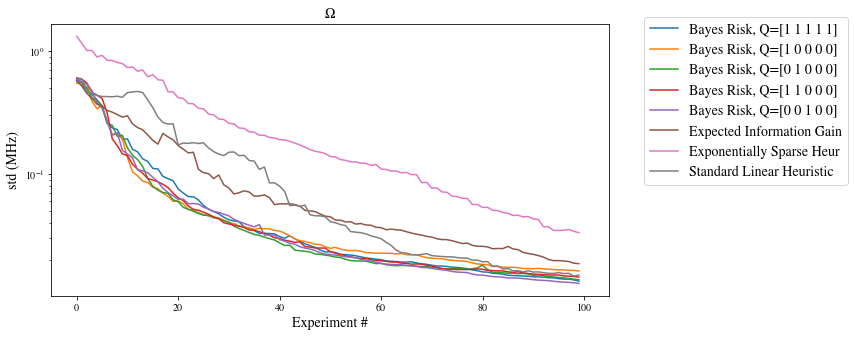

In [25]:
idx_model = 0
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-wr-variance')

Overwriting ../fig/qhl-we-variance.png
Overwriting ../fig/qhl-we-variance.pdf


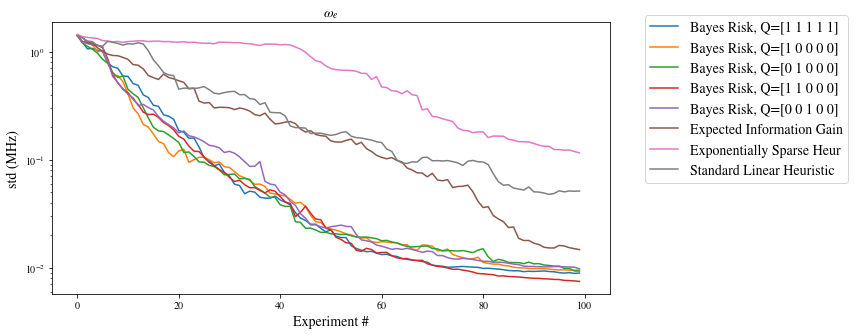

In [26]:
idx_model = 1
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-we-variance')

Saving ../fig/qhl-AN-variance.png
Saving ../fig/qhl-AN-variance.pdf


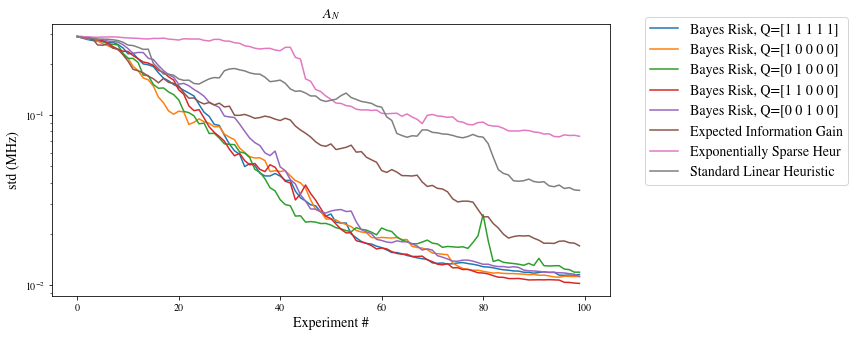

In [27]:
idx_model = 3
fig=plt.figure(figsize=(10,5))
for idx_h in range(n_updaters):
    h = heuristics[0][idx_h]
    plt.semilogy(np.mean(np.sqrt(track_covs[:,idx_h,:,idx_model,idx_model]),axis=0), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('${}$'.format(ham_model.modelparam_names[idx_model]))
plt.xlabel('Experiment #')
plt.ylabel('std (MHz)')
export_figure(fig, 'qhl-AN-variance')